# Objective

You own a diamond business and you have to replenish your inventory. You have $\$$5,000,000 budgeted towards the purchase of new diamonds. You have a historical list of diamonds that were purchased from various distributor vendors and the prices they retailed for. You also have a list of diamonds that are currently on the market, but this list does not include any set prices. Instead, you will place an offer for a diamond and the distributor will make a single yes-or-no decision to sell you the diamond at that price. If your offer is accepted then you receive the diamond and you will be awarded the difference between the retail price your company can eventually sell the diamond for and the price that you offered as profit. If you fail to make a purchase, you simply do not get anything for profit.
What you will return to Enova is a copy of any code used, a description of your process, answers to the short answer questions, and the offers file with the offer column populated. The offer column should be populated only on diamonds you wish to make an offer on, and the sum of the offers needs to be less than or equal to $5,000,000.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer



# Diamond Buying

Diamond grading standards use the 4C's:  

* __Carat__ refers to the weight of the diamond. A unit measurement equals 1/5 gram and is subdivided into 100 points.
* __Color__ is diamond tinge. Colorless diamonds are among the rarest. Other hues may be appear in diamonds. 
* __Clarity__ looks at the inclusions, the internal attributes, and blemishes, the external attributes. 
* __Cut__ affects the the diamond's overall radiance.


In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('training.csv')

# Data Exploration/Data Cleaning

In [3]:
df.head()

,id,Carats,Cert,Clarity,Color,Cut,Depth,Known_Conflict_Diamond,Measurements,Polish,Regions,Shape,Symmetry,Table,Vendor,Price,Retail,LogPrice,LogRetail
0,1,0.41,NaN,SI1,L,,65.40,False,4.65x4.62x3.03,Very good,Other/Unknown,Princess,Good,NaN,1,430,850,6.06,6.75
1,2,0.42,AGSL,SI2,L,,61.70,False,4.85x4.79x2.98,Excellent,Russia,Marquise,Very good,NaN,1,560,920,6.33,6.82
2,3,0.40,AGSL,SI1,L,,64.00,False,4.66x4.63x2.97,Excellent,South Africa,Round,Excellent,57.00,1,560,575,6.33,6.35
3,4,0.41,AGSL,SI2,L,,62.70,False,4.71x4.69x2.95,Very good,Botswana,Round,Very good,58.00,1,560,825,6.33,6.72
4,5,0.40,AGSL,SI1,L,,63.00,False,4.71x4.68x2.96,Excellent,Botswana,Round,Very good,58.00,1,580,890,6.36,6.79


In [4]:
df.shape

(8050, 19)

In [5]:
df.describe()

,id,Carats,Depth,Table,Vendor,Price,Retail,LogPrice,LogRetail
count,8050.00,8050.00,6610.00,5519.00,8050.00,8050.00,8050.00,8050.00,8050.00
mean,4025.50,1.27,61.72,57.95,2.05,15081.01,21494.78,8.80,9.13
std,2323.98,0.89,2.19,3.05,0.98,35642.61,51462.39,1.23,1.28
min,1.00,0.40,0.00,0.00,1.00,395.00,45.00,5.98,3.81
25%,2013.25,0.70,61.00,57.00,1.00,2690.00,3571.25,7.90,8.18
50%,4025.50,1.04,62.00,58.00,2.00,7050.00,10335.00,8.86,9.24
75%,6037.75,1.51,62.60,59.00,3.00,14660.00,20520.00,9.59,9.93
max,8050.00,11.92,69.70,69.00,4.00,1087785.00,1675190.00,13.90,14.33


In [6]:
# identiftying Carats max
df[df['Carats']==11.92]

,id,Carats,Cert,Clarity,Color,Cut,Depth,Known_Conflict_Diamond,Measurements,Polish,Regions,Shape,Symmetry,Table,Vendor,Price,Retail,LogPrice,LogRetail
6904,6905,11.92,GemEx,SI1,S,Fair,50.80,False,15.88x15.8x8.06,Very good,Botswana,Round,Good,69.00,2,154960,231695,11.95,12.35


In [7]:
# identiftying Price max
df[df['Price']==1087785.00]

,id,Carats,Cert,Clarity,Color,Cut,Depth,Known_Conflict_Diamond,Measurements,Polish,Regions,Shape,Symmetry,Table,Vendor,Price,Retail,LogPrice,LogRetail
4071,4072,8.13,AGSL,IF,F,,62.80,False,12.77x12.83x8.04,Excellent,Canada,Round,Excellent,NaN,2,1087785,1675190,13.90,14.33


The training dataset shows there are 8,050 purchases. On average the diamond size that has been purchased is 1.27 carats, however there was a diamond that was purchased at one point that was 11.92 carats. There are only four vendors that historically the diamonds have been purchased from. Price and Retail features have an outlier. From the third quartile to the max value Price jumps from $\$$14,660-$\$$1,087,785 which would be a ~7000% increase. The retail price jump is just as high for the Retail price. 

However, the diamond that is 11.92 carats isn't providing the max price and retail price. The 11.92 carat diamond is a lesser quality diamong with a SI1 clarity, S color, and Fair Cut. Purcahsed from Vendor 2 the price paid was $\$$154960 and sold at $\$$231695.

The diamond with the highest price and retail value is a 8.13 carat diamond with IF clarity, F color and unknown cut. This diamond ranks higher across other measures compared to the 11.92 carat diamond. This was purchased from Vendor 2 as well. 

Based on the table above, my initial assumptions show that Vendor 2 has sold a range of diamonds.

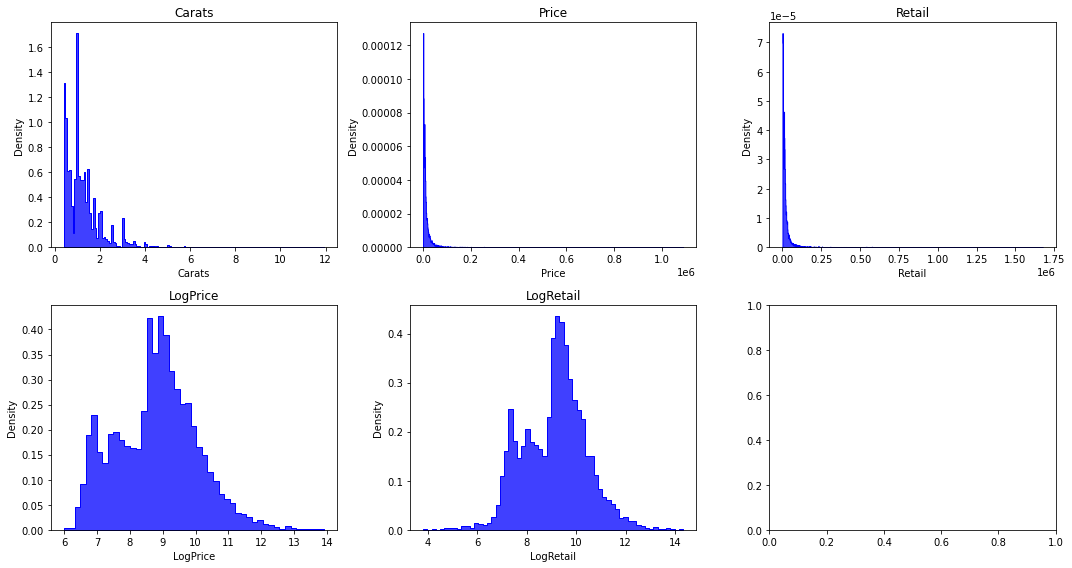

In [8]:
def plot_histograms(df, columns, nrows=2, ncols=3, fig_width=15, fig_height=8):
    fig, axs = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

    for i, column in enumerate(columns):
        row = i // ncols
        col = i % ncols
        sns.histplot(data=df, x=column, element='step', stat='density', common_norm=False, kde=False, color='blue', ax=axs[row, col])
        axs[row, col].set_title(column)

    plt.tight_layout()
    plt.show()
plot_histograms(df, ['Carats', 'Price', 'Retail', 'LogPrice', 'LogRetail'])


In [9]:
def remove_outliers(dataframe, columns):
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        dataframe = dataframe[(dataframe[col] > lower_bound) & (dataframe[col] < upper_bound)]
    return dataframe

# Remove outliers from Carats
df = remove_outliers(df, df[['Carats', 'Price', 'Retail']])

LogPrice and LogRetail have been transformed to be normally distributed, however Carats, Price and Retail features are  right-skewed, meaning there are more lower priced and smaller sized diamonds that were purchased in the past. The outliers need to be removed

In [10]:
df[['Carats','Price','Retail']].describe()

,Carats,Price,Retail
count,6899.00,6899.00,6899.00
mean,1.01,7101.19,10203.19
std,0.45,5677.42,8145.01
min,0.40,395.00,45.00
25%,0.60,2190.00,2975.00
50%,1.01,5805.00,8880.00
75%,1.30,10075.00,14777.50
max,2.65,26795.00,33920.00


After removing the Carats, Price, and retail outliers, the data count dropped 1151 records from the dataset. Now the Carats feature is a bit more normally distributed. Price and Retail are still a little right-skewed but we can assume normality because it looks like historically half of the diamond purchases have been less than $\$$5800. There might've been a few losses too because the minimum Price paid was $\$$395 but the minimum Retail was $\$$45. That's ~88% loss. It could be more if that isn't the same record.

In [11]:
# identiftying Retail min
df[df['Retail']==45.00]

,id,Carats,Cert,Clarity,Color,Cut,Depth,Known_Conflict_Diamond,Measurements,Polish,Regions,Shape,Symmetry,Table,Vendor,Price,Retail,LogPrice,LogRetail
523,524,0.40,AGSL,SI1,E,,61.40,True,4.72x4.69x2.89,Excellent,Angola,Uncut,Excellent,NaN,1,500,45,6.21,3.81


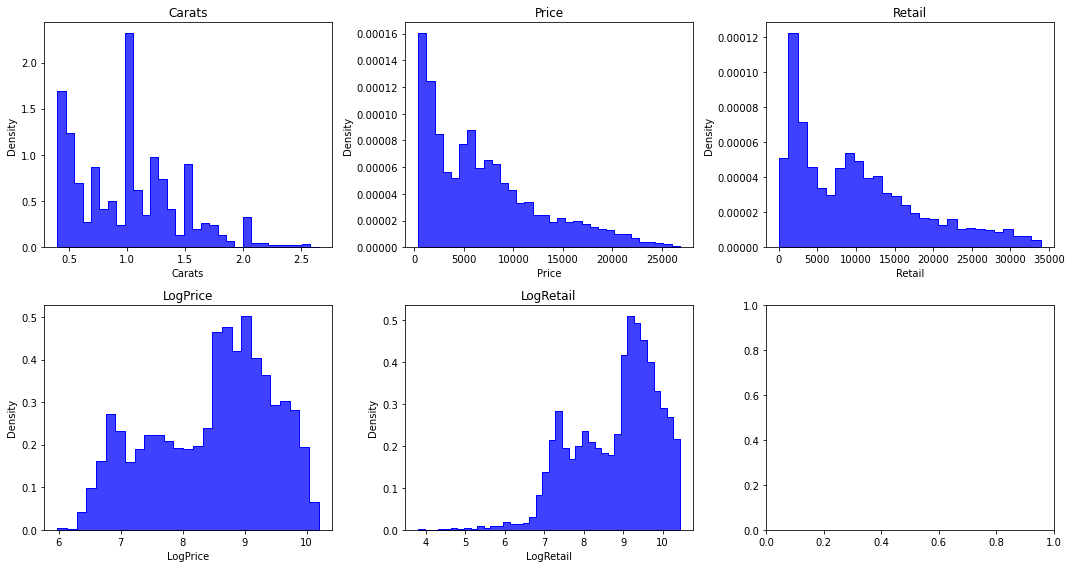

In [12]:
plot_histograms(df, ['Carats', 'Price', 'Retail', 'LogPrice', 'LogRetail'])


My initial assumptions were correct. After removing the outliers you the majority of diamond sizes that were purchesd are <1 carat. Price in the first bin makes up the majority of offer prices, which would be roughly $\$$1000 offers. Retail shows the second bin as the majority of what the diamonds are priced at roughly $\$$2000-3000. This shows that the distribution of profits mostly following the Price, but there are occasional losses on diamond purchases as noted in the first bin of Retail.

For the model, I'll be remapping the 3C's Color, Cut, and Clarity to AGS color scale since none of the certifications are GIA:
https://www.americangemsociety.org/understanding-diamond-color-the-4cs-of-diamonds/

In [13]:
df['Cert'].unique()

array([nan, 'AGSL', 'GemEx'], dtype=object)

In [14]:
df['Cert'] = df['Cert'].replace({np.nan: 'noCert'})

In [15]:
df['Clarity'].unique()

array(['SI1', 'SI2', 'VS2', 'VVS1', 'VS1', 'VVS2', 'I1', 'IF', 'I2', 'N',
       'I3', 'None'], dtype=object)

In [16]:
df['Clarity'] = df['Clarity'].map({'SI1': 'Slightly Included',
'SI2': 'Slightly Included',
'VS2': 'Very Slightly Included', 
'VVS1': 'Very Very Slightly Included', 
'VS1': 'Very Slightly Included', 
'VVS2': 'Very Very Slightly Included', 
'I1': 'Included', 
'IF': 'Flawless/IF', 
'FL': 'Flawless/IF', 
'I2': 'Included',
'I3': 'Included'})

In [17]:
df['Clarity'] = df['Clarity'].replace({np.nan: 'None'})

In [18]:
df['Color'].unique()

array(['L', 'M', 'K', 'J', 'F', 'I', 'H', 'G', 'E', 'D', 'N', 'Ffcly',
       'Ffcdbrown', 'Fvyellow', 'Fdy', 'Fyellow', 'U', 'Flyellow', 'Ffg',
       'Q-r', 'Lb', 'Fiyellow', 'Gy', 'Fdpink', 'Ffcy', 'P', 'Fiy', 'Fly',
       'W', 'O-p'], dtype=object)

In [19]:
df['Color'] = df['Color'].map({'L':'Faint',
'M':'Faint', 
'K':'Faint', 
'J':'Near Colorless', 
'F':'Colorless', 
'I':'Near Colorless', 
'H':'Near Colorless', 
'G':'Near Colorless', 
'E':'Colorless', 
'D':'Colorless', 
'N':'Very Light', 
'Ffcly':'Fancy Yellow',
'Ffcdbrown':'Fancy Yellow', 
'Fvyellow':'Fancy Yellow', 
'Fdy':'Fancy Yellow', 
'Fyellow':'Fancy Yellow', 
'U':'Light', 
'Flyellow':'Fancy Yellow', 
'Ffg':'Fancy Yellow',
'Q-r':'Very Light', 
'Lb':'Fancy Yellow', # doublecheck
'Fiyellow':'Fancy Yellow', 
'Gy':'Fancy Yellow', # doublecheck
'Fdpink':'Fancy Yellow', 
'Ffcy':'Fancy Yellow', 
'P':'Very Light', 
'Fiy':'Fancy Yellow', 
'Fly':'Fancy Yellow',
'W':'Light', 
'O-p':'Very Light'})

In [20]:
df['Cut'].unique()

array([' ', 'Excellent', 'Very good', 'Good', 'Fair'], dtype=object)

In [21]:
df['Cut'] = df['Cut'].replace({' ':'Uncut'})

In [22]:
df.isnull().sum()

id                           0
Carats                       0
Cert                         0
Clarity                      0
Color                        0
Cut                          0
Depth                     1232
Known_Conflict_Diamond       0
Measurements                 0
Polish                       0
Regions                      0
Shape                        0
Symmetry                     0
Table                     2139
Vendor                       0
Price                        0
Retail                       0
LogPrice                     0
LogRetail                    0
dtype: int64

In [23]:
# def preprocess_data(X, y):
#     """
#     Preprocesses the input data using a pipeline with SimpleImputer and StandardScaler.

#     Args:
#         X (pandas.DataFrame): Input data in a pandas DataFrame.
#         y (pandas.Series): Target variable in a pandas Series.

#     Returns:
#         pandas.DataFrame: Processed data in a pandas DataFrame.
#     """
#     # Create a pipeline with the imputer and scaler
#     preprocessor = make_pipeline(
#         SimpleImputer(strategy='mean'),
#         StandardScaler()
#     )

#     # Fit and transform the data using the pipeline
#     X_processed = preprocessor.fit_transform(X)

#     # Create a new DataFrame with the processed data
#     df_processed = pd.DataFrame(X_processed, columns=X.columns)

#     # Add the target variable to the new DataFrame
#     df_processed[y.name] = y

#     return df_processed
# X = df[['Depth', 'Table']]
# y = df['Price']
# df_processed = preprocess_data(X, y)


In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Select only the columns 'depth' and 'table' from your DataFrame
X = df[['Depth', 'Table']]
y = df['Price']

# Create a pipeline with the imputer and scaler
preprocessor = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

# Fit and transform the data using the pipeline
X_processed = preprocessor.fit_transform(X)

# Create a new DataFrame with the processed data
df_processed = pd.DataFrame(X_processed, columns=X.columns)

# Add the target variable to the new DataFrame
df_processed['Price'] = y


In [29]:
df_processed

,Depth,Table,Price
0,1.74,-0.00,430.00
1,-0.03,-0.00,560.00
2,1.07,-0.36,560.00
3,0.45,0.02,560.00
4,0.59,0.02,580.00
5,-0.89,2.27,580.00
6,0.78,0.02,580.00
7,0.31,0.39,585.00
8,0.00,0.02,585.00
9,0.55,-1.11,585.00


# EDA

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


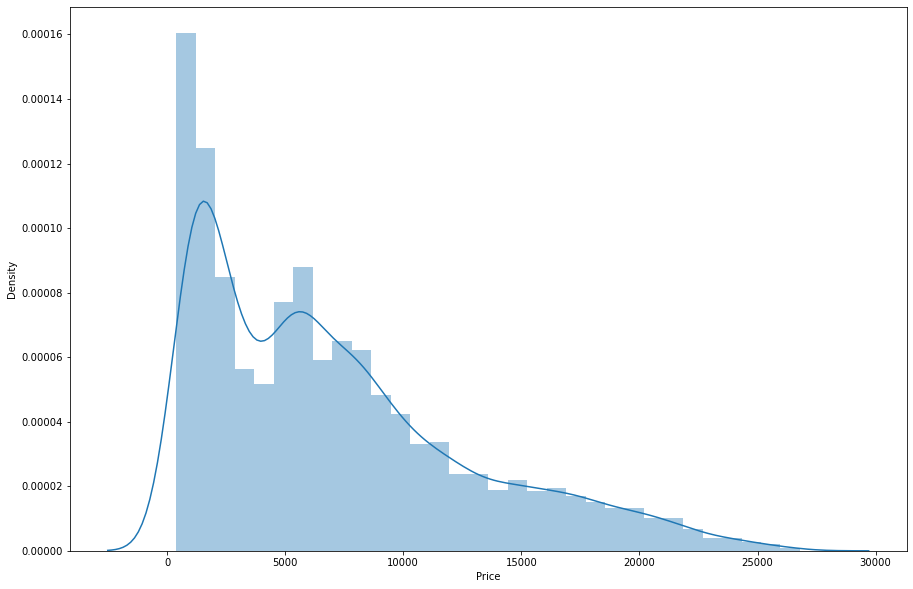

In [24]:
# Check the distribution of prices
plt.figure(figsize = (15,10))
sns.distplot(df['Price'])
plt.show()

In [25]:
def plot_4cs(df, y_col):
    # Create a figure with 2 subplots side by side
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # Check the relationship between carats and price
    sns.scatterplot(x='Carats', y=y_col, data=df, ax=axs[0,0])
    axs[0,0].set_title('Carats')

    # Check the relationship between price and other features
    sns.boxplot(x='Color', y=y_col, data=df, ax=axs[0,1])
    axs[0,1].set_title('Color')

    sns.boxplot(x='Clarity', y=y_col, data=df, ax=axs[1,0])
    axs[1,0].set_title('Clarity')

    sns.boxplot(x='Cut', y=y_col, data=df, ax=axs[1,1])
    axs[1,1].set_title('Cut')

    plt.tight_layout()
    plt.show()

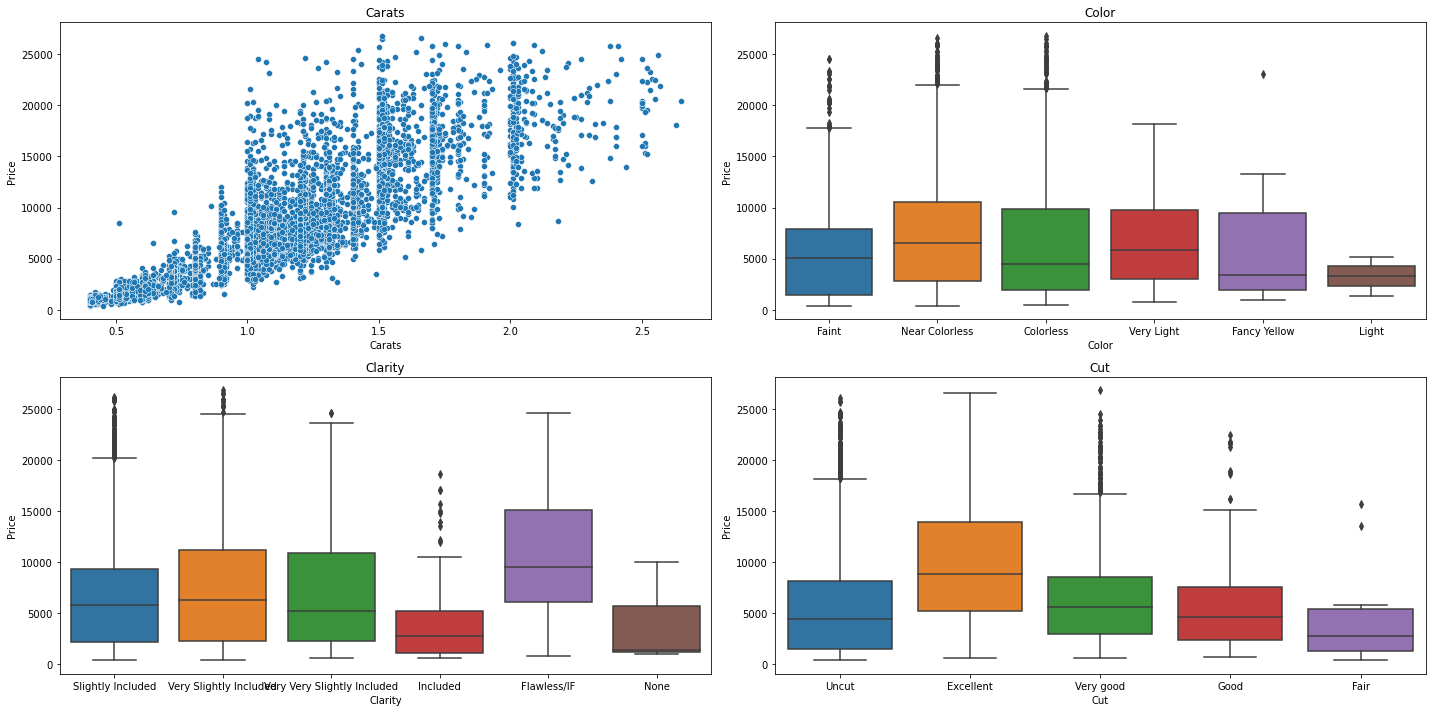

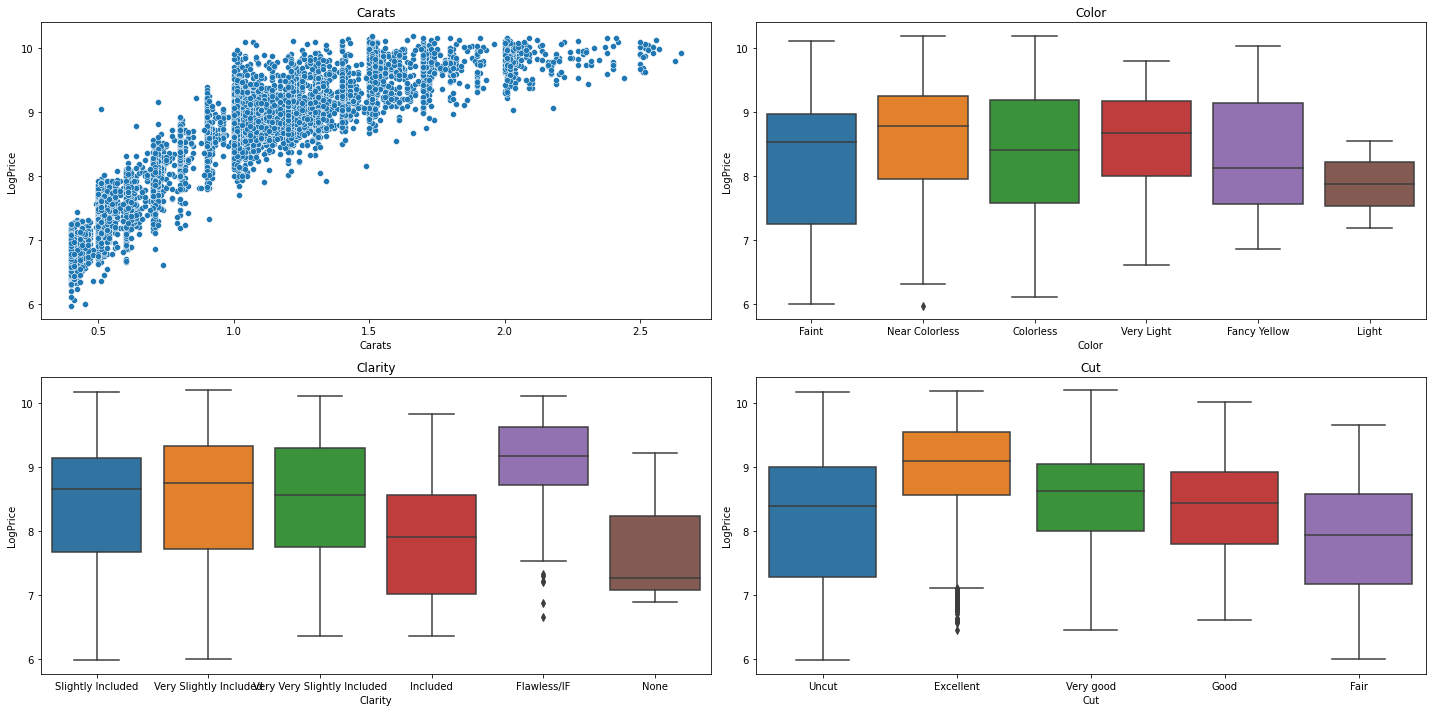

In [26]:
plot_4cs(df, 'Price')
plot_4cs(df, 'LogPrice')

In [ ]:
df.head()

Looking at the patterns between Price and the 4C's there isn't much deviance from the norm. Carats relative to Price shows a clear direct linear relationship. However, at each Carats there's a clear stacking, which I presume would be because of the other features that make up a quality diamond. What surprised me is that there isn't much deviation. I thought higher quality diamonds (Colorless, Flawless, Excellent) would have a higher spread. 

In [ ]:
df1 = df.groupby(['Vendor']).agg(Price = ('Price', 'sum'))
df1['Price']=df1['Price'].astype(int)
plot = df1['Price'].plot.pie(autopct='%1.1f%%')

Vendor 2 has 43% of purchase history

# Question 1

### Do you think that any of the vendors are over or under charging for diamonds compared to the other vendors? Do you think they are selling the same kind of diamonds? How did you come to this conclusion?

In [ ]:
# Which vendors are over or under charging:

# Check the distribution of prices for each vendor
sns.boxplot(x='Vendor', y='Price', data=df)
plt.show()

# Calculate the average price for each vendor
vendor_prices = df.groupby(['Vendor','Color','Cut','Clarity'])['Price'].mean()
vendor_prices_df = pd.DataFrame(vendor_prices)
vendor_prices_df.reset_index(inplace=True)

# Compare the vendor prices to the overall market prices
market_mean = df.groupby(['Color','Cut','Clarity'])['Price'].mean()
vendor_diff = vendor_prices - market_mean
vendor_diff_df = pd.DataFrame(vendor_diff)
vendor_diff_df.reset_index(inplace=True)

Vendor 2 has the widest spread, which confirms my inital assumption that Vendor 2 has sold a wide variety of diamonds since there are outliers. Vendor 2 and 3 more or less price their diamonds the same. Vendor 4 has the highest spread level, which may mean Vendor 4 has the higher prices. The mean price from Vendor 4 is the highest. Vendor 1 has the lowest spread, which might indicate they're the ones selling the lowest quality diamonds.

In [ ]:
# Add a column for the market mean price
df = df.merge(market_mean.reset_index().rename(columns={'Price': 'market_mean_price'}), 
              on=['Color','Cut','Clarity'], how='left')

# Add a column for the vendor prices
df = df.merge(vendor_prices.reset_index().rename(columns={'Price': 'vendor_price'}), 
              on=['Vendor','Color','Cut','Clarity'], how='left')

# Calculate the difference between vendor prices and market mean prices
df['difference'] = df['vendor_price'] - df['market_mean_price']

To assess if a vendor is over or undercharging a mean market price given a diamond's Cut, Color, and Clarity is determined. Then a vendor price given the diamond quality (Cut, Color, and Clarity) must be considered as well. Then the difference between vendor and market price will assess if a vendor is over or under charging.

In [ ]:
overcharge_df = df[df['difference'] > 0]
grouped_vendor_df = overcharge_df.groupby('Vendor').sum().sort_values('difference', ascending=False)
print(grouped_vendor_df)

__Vendor 4 is overcharging given the Color, Cut, and Clarity of the diamond__. Vendor 2 could most likely be overcharging as well given the spread and mean price is the same as Vendor 3, however given the amount of outliers Vendor 2 has it can't be determined at this point.

# Question 2

### What is the relationship between Carat and Retail Price? Why do you think the relationship takes this form?

From the visuals above, the relationship between Carat and Retail price follow a clear direct linear relationship. meaning that as the carat weight of a diamond increases, the retail price will increase. The logic for this is because larger diamonds are not common and considered rare. Because of the infrequency a rare diamond comes on the market a diamond's value will increase leading to a higher price.

# Model Build
I'm going to use an ordinal encoding for color, clarity and cut and one hot encode the certification since it's not. ordinal

In [ ]:
df['Cut'] = df['Cut'].replace({'Excellent':4, 'Very good':3, 'Good':2, 'Fair':1, 'Uncut':0})
df['Color'] = df['Color'].replace({'Colorless':6, 'Near Colorless':5, 'Faint':4,'Very Light':3,'Light':2, 'Fancy Yellow':1})
df['Clarity'] = df['Clarity'].replace({'Flawless/IF':5, 'Very Very Slightly Included':4, 'Very Slightly Included':3, 'Slightly Included':2, 'Included':1, 'None':0})

In [ ]:
df = pd.get_dummies(df, columns =['Cert', 'Known_Conflict_Diamond', 'Regions', 'Shape', 'Symmetry', 'Polish'])

In [ ]:
df.shape

In [ ]:
df[['x', 'y', 'z']] = df['Measurements'].str.split('x', expand=True)
df[['x', 'y', 'z']] = df[['x', 'y', 'z']].astype(float)
df = df.drop(columns=['Measurements'])

The pearson correlation coefficient is calculated to get the general strength and direction of the relationship between the two variables.

In [ ]:
corr = df.drop('id', axis=1).corr().round(2)
plt.figure(figsize = (40,40))
sns.heatmap(corr, annot = True, cmap = 'YlOrBr')

Use all features that aren't highly correlated to Price.

In [ ]:
# y = df['Price']
# X = df.drop(['id','Price','Retail','LogPrice','LogRetail','market_mean_price','vendor_price','difference','x','y','z'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=312)
# print(X_train.shape,y_train.shape)
# print(X_test.shape,y_test.shape)

# # Initialize the regression model
# regression = LinearRegression()

# # Fit the model on the PCA transformed data
# regression.fit(X_train, y_train)

# # Predict on new data
# y_pred = regression.predict(X_test)


# print(f'Intercept: {regression.intercept_:.3f}')

# print('Coefficients:')
# for name, coef in zip(X, regression.coef_):
#     print(f' {name}: {coef}')

# # Initialize k-fold cross-validator
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # Initialize lists to store the scores
# mae_scores = []
# mse_scores = []
# r2_scores = []

# # Perform k-fold cross-validation
# for train_index, test_index in kf.split(X):
#     X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
#     y_cv_train, y_cv_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regression.fit(X_cv_train, y_cv_train)

#     # Predict on the test data
#     y_pred = regression.predict(X_cv_test)

#     # Calculate evaluation metrics
#     mae = mean_absolute_error(y_cv_test, y_pred)
#     mse = mean_squared_error(y_cv_test, y_pred)
#     r2 = r2_score(y_cv_test, y_pred)

#     # Append the scores to the lists
#     mae_scores.append(mae)
#     mse_scores.append(mse)
#     r2_scores.append(r2)
    
# print('Mean Absolute Error:', np.mean(mae_scores))
# print('Mean Squared Error:', np.mean(mse_scores))
# print('R^2 Score:', np.mean(r2_scores))

This model uses a linear regression model that is being trained on the data, with the goal of predicting the 'Price' variable based on low correlated features in the dataframe. The model is also using k-fold cross-validation (with 10 folds) to evaluate its performance, which is a technique to assess the generalization performance of a model by splitting the data into a training and testing set multiple times, where each time a different portion of the data is used as the testing set. The evaluation metrics that are reported are the mean absolute error (MAE), mean squared error (MSE), and R-squared score (R^2).

* The Mean Absolute Error (MAE) is a measure of how close the predictions are to the true values. It is the average difference between the true and predicted values, and it is measured in the same units as the target variable. 

* The Mean Squared Error (MSE) is a measure of how close the predictions are to the true values. It is the average of the squared differences between the true and predicted values, and it is measured in the same units as the target variable. 

* The R^2 Score (R-squared score) is a measure of how much of the variability in the target variable is explained by the model. It ranges between 0 and 1, where 1 is a perfect fit and 0 is a poor fit. 

The R^2 score of 0.8595493996256692 suggests that the model has a good fit to the data, as it's close to 1. The MAE and MSE are also relatively low, indicating that the model's predictions are close to the true values.

The MAE indicates that on average, the model's predictions are off by $\$$1559.
The MSE is 4521076, indicating that the model's predictions have a $\$$4M spread.
The R^2  score indicates that the model explains around 86% of the variance in the target variable (Retail).

In [ ]:
# Define the features and target variable
X = df.drop(['id', 'Price', 'Retail', 'LogPrice', 'LogRetail', 'market_mean_price', 'vendor_price', 'difference', 'x', 'y', 'z'], axis=1)
y = df['Price']

# Define the pipeline with preprocessing and model
pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

# Define the grid of hyperparameters to search over
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [10, 20, 30, None],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
}

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)

# Extract the best model from the grid search
best_model = grid_search.best_estimator_

# Perform k-fold cross-validation on the best model
scores = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    best_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append the scores to the list
    scores.append((mae, mse, r2))

# Print the average scores across folds
mae_scores, mse_scores, r2_scores = zip(*scores)
print('Mean Absolute Error:', np.mean(mae_scores))
print('Mean Squared Error:', np.mean(mse_scores))
print('R^2 Score:', np.mean(r2_scores))


PCA

In [ ]:
# Select the features you want to include in your PCA analysis
X = df.drop(['id','Price','Retail','LogPrice','LogRetail','market_mean_price','vendor_price','difference','x','y','z'], axis=1)

# Initialize the PCA transformer
pca = PCA(n_components=0.95)

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Initialize the regression model
regression = LinearRegression()

# Fit the model on the PCA transformed data
regression.fit(X_pca, df['Price'])

# Predict on new data
y_pred = regression.predict(X_pca)

print(f'Intercept: {regression.intercept_:.3f}')

print('Coefficients:')
for name, coef in zip(X, regression.coef_):
    print(f' {name}: {coef}')
    
# Initialize k-fold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store the scores
mae_scores = []
mse_scores = []
r2_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = df['Price'][train_index], df['Price'][test_index]

    # Fit the model on the training data
    regression.fit(X_train, y_train)

    # Predict on the test data
    y_pred = regression.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append the scores to the lists
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)
    
print('Mean Absolute Error:', np.mean(mae_scores))
print('Mean Squared Error:', np.mean(mse_scores))
print('R^2 Score:', np.mean(r2_scores))

This model uses a linear regression model that is being trained on the data, with the goal of predicting the 'Price' variable based on PCA selected features. PCA reduces dimensionality of the dataset while perserving as much variance. The model is also uses a k-fold cross-validation (with 10 folds) to evaluate its performance. The evaluation metrics that are reported are the mean absolute error (MAE), mean squared error (MSE), and R-squared score (R^2).

The R^2 score of 0.8510699390654283 suggests that the model has a good fit to the data, as it's close to 1. The MAE and MSE are also relatively low, indicating that the model's predictions are close to the true values.

The MAE indicates that on average, the model's predictions are off by $\$$1596, $\$$37 higher than the previous model
The MSE is 4795140, indicating that the model's predictions have a $\$$4M spread.
The R^2  score indicates that the model explains around 85% of the variance in the target variable (Retail).

Comparing the two models, both have similar performance, with the second model having a slightly higher MAE and MSE but also a slightly lower R^2 score. However, the difference is small, and both models are considered to have good performance. The first model is simpler and uses all the features of the data, but the second model uses PCA to reduce the dimensionality of the data and to find patterns in the data that are not easily visible in the original features.

# Offers

## EDA

In [ ]:
df_offers = pd.read_csv('offers.csv')
# Data Cleaning

In [ ]:
df_offers.describe()

In [ ]:
# Create a histogram for carats and add to first subplot
sns.histplot(data=df_offers, x='Carats', element='step', stat='density', common_norm=False, kde=False, color = 'blue')
plt.tight_layout()
plt.show()


## PreProcessing

In [ ]:
def remove_outliers(dataframe, columns):
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        dataframe = dataframe[(dataframe[col] > lower_bound) & (dataframe[col] < upper_bound)]
    return dataframe
df_offers = remove_outliers(df_offers, ['Carats'])

In [ ]:
df_offers['Cert'].unique()

In [ ]:
df_offers['Cert'] = df_offers['Cert'].replace({np.nan: 'noCert'})

In [ ]:
df_offers['Clarity'].unique()

In [ ]:
df_offers['Clarity'] = df_offers['Clarity'].map({'SI1': 'Slightly Included',
'SI2': 'Slightly Included',
'VS2': 'Very Slightly Included', 
'VVS1': 'Very Very Slightly Included', 
'VS1': 'Very Slightly Included', 
'VVS2': 'Very Very Slightly Included', 
'I1': 'Included', 
'IF': 'Flawless/IF', 
'FL': 'Flawless/IF', 
'I2': 'Included',
'I3': 'Included'})

In [ ]:
df_offers['Color'].unique()

In [ ]:
df_offers['Color'] = df_offers['Color'].map({'L':'Faint',
'M':'Faint', 
'K':'Faint', 
'J':'Near Colorless', 
'F':'Colorless', 
'I':'Near Colorless', 
'H':'Near Colorless', 
'G':'Near Colorless', 
'E':'Colorless', 
'D':'Colorless', 
'N':'Very Light',
'S-t':'Light', 
'T':'Light',
'Ffancy darkbrown':'Fancy Yellow',
'Flby':'Fancy Yellow'})

In [ ]:
df_offers['Cut'].unique()

In [ ]:
df_offers['Cut'] = df_offers['Cut'].replace({' ':'Uncut'})

In [ ]:
df_offers['Known_Conflict_Diamond'].unique()

In [ ]:
df_offers['Known_Conflict_Diamond'] = df_offers['Known_Conflict_Diamond'].replace({np.nan: 'Unknown'})

In [ ]:
df_offers.isnull().sum()

In [ ]:
X = df[['Depth', 'Table']]
y = df['Price']
df = preprocess_data(X, y)

In [ ]:
df_offers['Cut'] = df_offers['Cut'].replace({'Excellent':4, 'Very good':3, 'Good':2, 'Fair':1, 'Uncut':0})
df_offers['Color'] = df_offers['Color'].replace({'Colorless':6, 'Near Colorless':5, 'Faint':4,'Very Light':3,'Light':2, 'Fancy Yellow':1})
df_offers['Clarity'] = df_offers['Clarity'].replace({'Flawless/IF':5, 'Very Very Slightly Included':4, 'Very Slightly Included':3, 'Slightly Included':2, 'Included':1, 'None':0})

In [ ]:
df_offers = pd.get_dummies(df_offers, columns =['Cert', 'Known_Conflict_Diamond', 'Regions', 'Shape', 'Symmetry', 'Polish'])

In [ ]:
df_offers.head()

In [ ]:
df_offers.shape

In [ ]:
df_offers.describe()

## Model

In [ ]:
# Initialize the PCA transformer
pca = PCA(n_components=15)

# Select the features you want to include in your PCA analysis
X = df_offers.drop(['id','Measurements','Offers'], axis=1)

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Predict the offer price using the trained model
offers_pred = regression.predict(X_pca)

# Replace negative values with 0
offers_pred = np.maximum(offers_pred, 0)

# Add the predicted offer prices to the offers dataset
df_offers['Offers'] = offers_pred


In [ ]:
df_offers.head()

In [ ]:
# Ensure the total sum of offers is less than or equal to $5,000,000
if df_offers['Offers'].sum() > 5000000:
    raise ValueError('Total sum of offers exceeds budget')

In [ ]:
# Check the relationship between carats and price
sns.scatterplot(x='Carats', y='Offers', data=df_offers)
plt.tight_layout()
plt.show()

Since we got the ValueError above, another step must be taken to determine which diamonds to make an offer on. First Offers will be sorted with top offers first. The script will then go through each row to check the current offer plus the total susum is over the $\$$5M budget. If it is then the row offer is replaced with a 0, removing the offer on the diamond. This script will continue through the rows until the sum of offers hit under budget.

In [ ]:
# Sort the diamonds by the predicted offer price in descending order
df_offers = df_offers.sort_values(by='Offers', ascending=False)

# Initialize a variable to track the total sum of offers
total_offers = 0

# Iterate through the sorted dataset
for i, row in df_offers.iterrows():
    # Check if the current offer price plus the total sum of offers exceeds the budget
    if total_offers + row['Offers'] > 5000000:
        # If it does, remove the offer from this diamond
        df_offers.at[i, 'Offers'] = 0
    # Update the total sum of offers
    total_offers += df_offers.at[i, 'Offers']

In [ ]:
# Show the final dataset
df_offers.head()

In [ ]:
# Ensure the total sum of offers is less than or equal to $5,000,000
if df_offers['Offers'].sum() > 5000000:
    raise ValueError('Total sum of offers exceeds budget')
else:
    print('We are within budget')

In [ ]:
# getting only ID and offers feature to join onto original dataframe
df_offers = df_offers.loc[:, ['id', 'Offers']]
df_offers

In [ ]:
df_offers_FINAL = pd.read_csv('offers.csv')

In [ ]:
# Join the two dataframes on the 'id' column
df_offers_FINAL.drop(columns=['Offers'], inplace=True)
df_offers_FINAL = df_offers_FINAL.merge(df_offers, on='id', how='left')
df_offers_FINAL.to_csv('offers.csv', index=False)